In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time 
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import math
from PIL import Image
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import kagglehub
from torchvision.transforms import v2 # Torch documentions mention that v2 is a better than plain transforms. I will still use transforms for the testing set as it has been depricated in v2 and is a much longer process to get the same result rather than just using the original 'transforms'.

In [2]:
# Downloading the CIFAR10 dataset
path = kagglehub.dataset_download("gazu468/cifar10-classification-image")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifar10-classification-image


In [3]:
# Creating custom datasets and converting to tensor.
try:
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset=datasets.ImageFolder(root=f"{path}/cifar10/train",transform=transform)
    test_dataset=datasets.ImageFolder(root=f"{path}/cifar10/test",transform=transform)
    print('Finally able to make it to custom dataset.')

except Exception as e:
    print(f'dataset name is still probably off.. {e}')

Finally able to make it to custom dataset.


In [4]:
# Checking the results
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [5]:
# Custom data loader...
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False) # Don't need to shuffle for testing set, as we discussed in class...
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Done')

Done


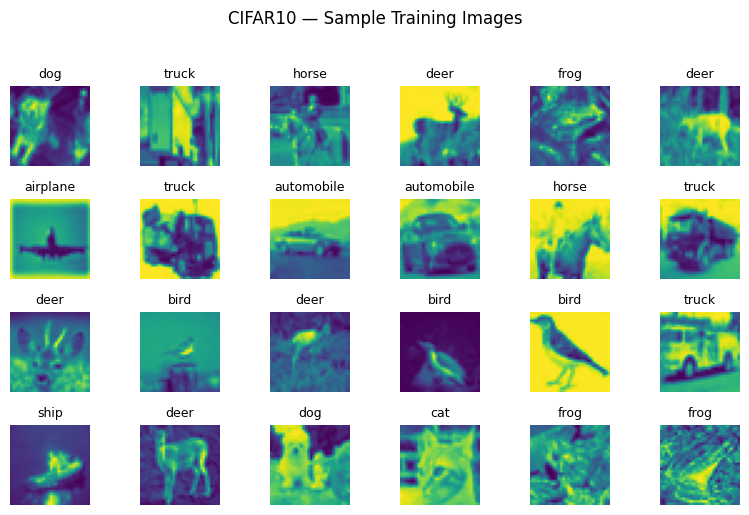

Batch tensor shape: torch.Size([128, 3, 32, 32]) | dtype: torch.float32


In [7]:
# Just looking at the data. Returning a sample of 24 images with their corresponding labels. Categorical turned numberic once it hits the dataloader.
images, labels = next(iter(train_loader))
class_names = getattr(train_loader.dataset, "classes", [str(i) for i in range(10)])

k = 24
rows, cols = 4, 6
fig, axs = plt.subplots(rows, cols, figsize=(8,5))
axs = axs.ravel()
for i in range(k):
    axs[i].imshow(images[i, 0].numpy())
    axs[i].set_title(class_names[int(labels[i])], fontsize=9)
    axs[i].axis("off")
for j in range(k, rows*cols):
    axs[j].axis("off")
plt.suptitle("CIFAR10 — Sample Training Images", y=1.02)
plt.tight_layout()
plt.show()

print("Batch tensor shape:", images.shape, "| dtype:", images.dtype)

# **Task 1**

In [9]:
# Baseline model
class CNN(nn.Module):
    def __init__(self, classes=10):
        super().__init__()

        # Throughout this class we will see bias=False in the nn.Conv2d layers where BatchNorm2d follows. This is because BatchNorm2d introduces its own learnable params...
        self.stem = nn.Sequential( # 2 3x3 convolution layers...
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias = False), # First conv layer.
            nn.BatchNorm2d(32), # Normalization
            nn.ReLU(), # Nonlinear activation function

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv_block_1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, padding=0, stride=1, bias = False), # Point-wise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, groups=128, bias = False), # Depth-wise convolution. Has to be same as in_channels and postive integer for out_channels.
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 convolution
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # Stacked 3x3 convolution.
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Downample with max pooling
        self.pooling1 = nn.MaxPool2d(2)

        self.conv_block_2 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0, stride=1, bias = False), #point-wise convolution on conv block 2
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, groups=256, bias = False), # depth-wise conv
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), #3x3 conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv stacked
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.pooling2 = nn.MaxPool2d(2)

        self.conv_block_3 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0, stride=1, bias = False), # point-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, groups=512, bias = False), #depth-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv layer
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # stacked 3x3
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        self.pooling3 = nn.MaxPool2d(2)

        # Flattening and linear (MLP head)
        self.fc = nn.Sequential(
            nn.Flatten(), # Flattening the dataset
            nn.Linear(1024 * 4 * 4, 2048), # 4x4 known from downsampling. Bias will remain its default of True here as no batch normalization follows...
            nn.ReLU(),
            #nn.Dropout(0.5), # No regularization technique for the baseline model in accordance to the directions.

            nn.Linear(2048, 1024),
            nn.ReLU(),
            #nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(512, classes)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.conv_block_1(x)
        x = self.pooling1(x) # Max pooling step after conv block 1.
        x = self.conv_block_2(x)
        x = self.pooling2(x)
        x = self.conv_block_3(x)
        x = self.pooling3(x)
        x = self.fc(x)
        return x

In [10]:
# Model and optimizer
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [11]:
# Defining the training loop
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train epoch {epoch +1}: Loss={loss.item():.4f}')

In [12]:
# Defining the testing loop
def test():
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0,0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.numel()

            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
    acc = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.2f}%')

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Using actual class names
    class_names = getattr(test_loader.dataset, "classes", None)

    labels = np.arange(len(class_names))

    cm_raw  = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')  # sums to 1

    totals  = cm_raw.sum(axis=1)
    correct_per_class = np.diag(cm_raw)
    per_cls_acc = np.divide(correct_per_class, totals, out=np.zeros_like(correct_per_class, dtype=float), where=totals>0) * 100.0

    # Accuracy table per class
    print("Accuracy table classification for baseline")
    print(f"{'Class':<12} {'Correct/Total':>16} {'Accuracy %':>12}")
    for i, name in enumerate(class_names):
        ct = f"{int(correct_per_class[i])}/{int(totals[i])}"
        print(f"{name:<12} {ct:>16} {per_cls_acc[i]:>12.2f}")

    # Confusion matrix
    np.set_printoptions(linewidth=160, suppress=True)
    print("Confusion Matrix baseline(raw counts):\n", cm_raw)
    print("Confusion Matrix baseline(row-normalized):\n", cm_norm)

    # Brief interpretation: top 5 confusions
    off = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_norm[i, j] > 0:
                off.append((cm_norm[i, j], i, j))
    off.sort(reverse=True)
    print("Notable confusions for baseline (top 5):")
    for v, i, j in off[:5]:
        print(f"  {class_names[i]} was misclassified as: {class_names[j]}: {v*100:.2f}%")

    ConfusionMatrixDisplay(cm_raw, display_labels=class_names).plot(values_format='d'); plt.title("Raw Count for Baseline"); plt.show()
    ConfusionMatrixDisplay(cm_norm, display_labels=class_names).plot(values_format='.2f'); plt.title("Normalized Result for Baseline"); plt.show()

Train epoch 1: Loss=1.6571
Train epoch 2: Loss=1.1577
Train epoch 3: Loss=0.8708
Train epoch 4: Loss=0.8828
Train epoch 5: Loss=0.7055
Test Accuracy: 76.59%
Accuracy table classification for baseline
Class           Correct/Total   Accuracy %
airplane             829/1000        82.90
automobile           929/1000        92.90
bird                 688/1000        68.80
cat                  563/1000        56.30
deer                 818/1000        81.80
dog                  695/1000        69.50
frog                 828/1000        82.80
horse                810/1000        81.00
ship                 765/1000        76.50
truck                734/1000        73.40
Confusion Matrix baseline(raw counts):
 [[829  18  60  20  18   1   8  26  14   6]
 [  9 929  12   8   1   2  12   5   2  20]
 [ 60   3 688  32 102  39  58  17   1   0]
 [ 19   6  78 563  74 166  52  36   3   3]
 [ 13   1  44  44 818  15  29  34   2   0]
 [  3   8  65 104  48 695  15  60   0   2]
 [  4   4  46  43  57  16 828

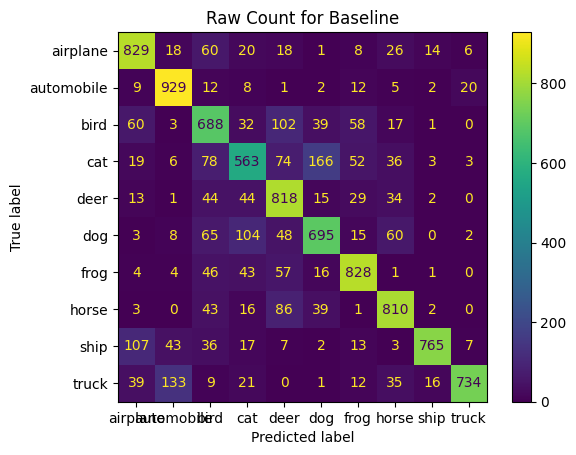

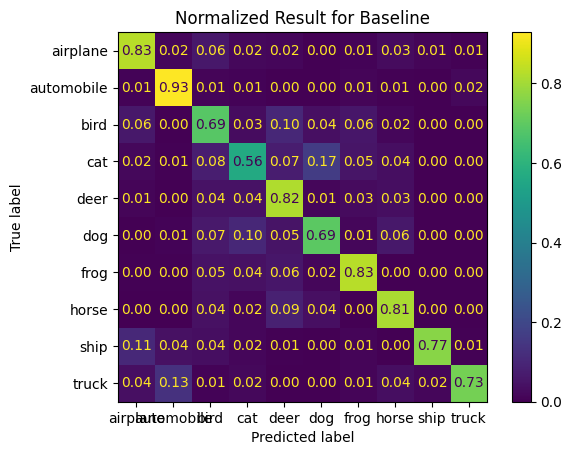

End of baseline model


In [13]:
# Performing train/test.
for epoch in range(5):
    train(epoch)
test()
print('End of baseline model')

In [14]:
# Redo, but now with Dropout regularization implemented.
class CNN_Dropout(nn.Module):
    def __init__(self, classes=10):
        super().__init__()

        # Throughout this class we will see bias=False in the nn.Conv2d layers where BatchNorm2d follows. This is because BatchNorm2d introduces its own learnable params...
        self.stem = nn.Sequential( # 2 3x3 convolution layers...
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias = False), # First conv layer.
            nn.BatchNorm2d(32), # Normalization
            nn.ReLU(), # Nonlinear activation function

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv_block_1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, padding=0, stride=1, bias = False), # Point-wise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, groups=128, bias = False), # Depth-wise convolution. Has to be same as in_channels and postive integer for out_channels.
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 convolution
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # Stacked 3x3 convolution.
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Downample with max pooling
        self.pooling1 = nn.MaxPool2d(2)

        self.conv_block_2 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0, stride=1, bias = False), #point-wise convolution on conv block 2
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, groups=256, bias = False), # depth-wise conv
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), #3x3 conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv stacked
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.pooling2 = nn.MaxPool2d(2)

        self.conv_block_3 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0, stride=1, bias = False), # point-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, groups=512, bias = False), #depth-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv layer
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # stacked 3x3
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        self.pooling3 = nn.MaxPool2d(2)

        # Flattening and linear (MLP head)
        self.fc = nn.Sequential(
            nn.Flatten(), # Flattening the dataset
            nn.Linear(1024 * 4 * 4, 2048), # 4x4 known from downsampling. Bias will remain its default of True here as no batch normalization follows...
            nn.ReLU(),
            nn.Dropout(0.2), # Regularization technique. 20% dropped out in accordance to the assignment guidlines...

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, classes)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.conv_block_1(x)
        x = self.pooling1(x) # Max pooling step after conv block 1.
        x = self.conv_block_2(x)
        x = self.pooling2(x)
        x = self.conv_block_3(x)
        x = self.pooling3(x)
        x = self.fc(x)
        return x

In [15]:
# Model and optimizer
model = CNN_Dropout().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [16]:
# Defining the training loop
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train epoch {epoch +1}: Loss={loss.item():.4f}')

In [17]:
# Defining the testing loop
def test():
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0,0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.numel()

            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
    acc = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.2f}%')

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Using actual class names
    class_names = getattr(test_loader.dataset, "classes", None)

    labels = np.arange(len(class_names))

    cm_raw  = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')  # sums to 1

    totals  = cm_raw.sum(axis=1)
    correct_per_class = np.diag(cm_raw)
    per_cls_acc = np.divide(correct_per_class, totals, out=np.zeros_like(correct_per_class, dtype=float), where=totals>0) * 100.0

    # Accuracy table per class
    print("Accuracy table classification")
    print(f"{'Class':<12} {'Correct/Total':>16} {'Accuracy %':>12}")
    for i, name in enumerate(class_names):
        ct = f"{int(correct_per_class[i])}/{int(totals[i])}"
        print(f"{name:<12} {ct:>16} {per_cls_acc[i]:>12.2f}")

    # Confusion matrix
    np.set_printoptions(linewidth=160, suppress=True)
    print("Confusion Matrix (raw counts):\n", cm_raw)
    print("Confusion Matrix (row-normalized):\n", cm_norm)

    # Brief interpretation: top 5 confusions
    off = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_norm[i, j] > 0:
                off.append((cm_norm[i, j], i, j))
    off.sort(reverse=True)
    print("Notable confusions (top 5):")
    for v, i, j in off[:5]:
        print(f"  {class_names[i]} was misclassified as: {class_names[j]}: {v*100:.2f}%")

    ConfusionMatrixDisplay(cm_raw, display_labels=class_names).plot(values_format='d'); plt.title("Raw Count"); plt.show()
    ConfusionMatrixDisplay(cm_norm, display_labels=class_names).plot(values_format='.2f'); plt.title("Normalized Result"); plt.show()

Train epoch 1: Loss=1.7863
Train epoch 2: Loss=1.4042
Train epoch 3: Loss=1.2582
Train epoch 4: Loss=1.0455
Train epoch 5: Loss=0.8133
Test Accuracy: 72.47%
Accuracy table classification
Class           Correct/Total   Accuracy %
airplane             681/1000        68.10
automobile           916/1000        91.60
bird                 529/1000        52.90
cat                  534/1000        53.40
deer                 637/1000        63.70
dog                  770/1000        77.00
frog                 867/1000        86.70
horse                721/1000        72.10
ship                 757/1000        75.70
truck                835/1000        83.50
Confusion Matrix (raw counts):
 [[681  39 134  23  12  10  11   9  32  49]
 [  4 916   1  10   2   5   9   0   3  50]
 [ 41  10 529 103  80  87 125  18   3   4]
 [  5  13  39 534  32 265  88  14   2   8]
 [ 13   5  45  91 637  33 112  59   3   2]
 [  2   6  21 147  16 770  13  24   1   0]
 [  2   4  10  97   5  12 867   0   0   3]
 [  7  

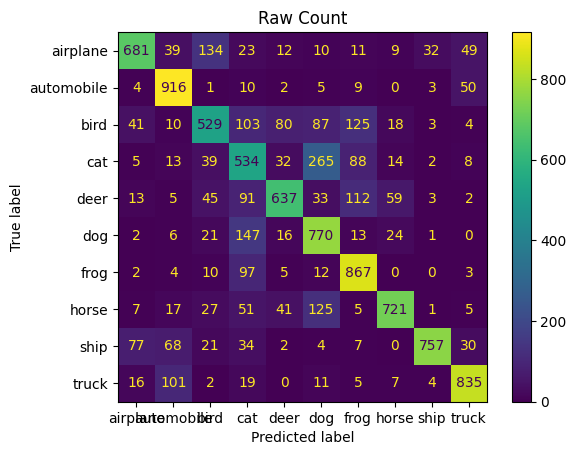

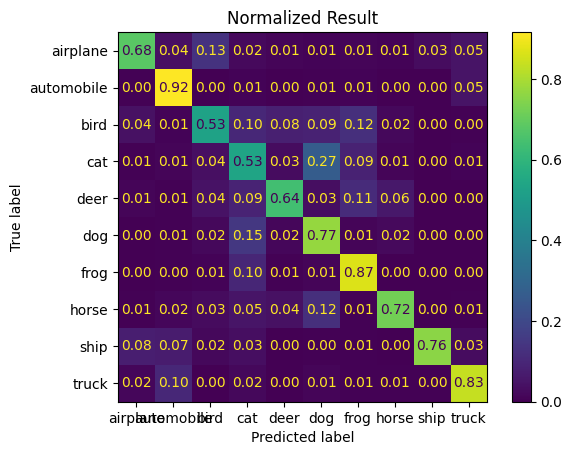

End of dropout only model


In [18]:
# Performing train/test.
for epoch in range(5):
    train(epoch)
test()
print('End of dropout only model')

In [19]:
# Redo 3, but now with NO Dropout regularization implemented but implemented 3 augmentation techniques.



# Creating custom datasets and converting to tensor.
# try:
#     transform = transforms.Compose([transforms.ToTensor()])
#     train_dataset=datasets.ImageFolder(root=f"{path}/cifar10/train",transform=transform)
#     test_dataset=datasets.ImageFolder(root=f"{path}/cifar10/test",transform=transform)
#     print('Finally able to make it to custom dataset.')

# except Exception as e:
#     print(f'dataset name is still probably off.. {e}')

# Same dataset that we used for above, but I am wanting to get the mean/std of each 3 channels for the augmentation process...
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True  )
data = cifar_trainset.data / 255 
mean = data.mean(axis = (0,1,2)) 
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}")

100%|██████████| 170M/170M [00:02<00:00, 69.1MB/s] 


Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [26]:
# Augmentation performed on train set, none on testing just setting to tensor...
train_transform = transforms.Compose([
    v2.RandomCrop(32, padding=2),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness = 0.5, contrast = (0.5, 1.0), saturation = (0.1, 0.5), hue = (-0.1, 0.1)),
    v2.ToTensor(),
    v2.Normalize(mean,std)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [27]:
"""
Now that I have the transforms set up I will revert back to the original dataset that I downloaded and used at the beginning of this noteobook and not the one from torch.
I am doing this because I just want to make sure it has the exact same lineup when training/testing as the previous models.
"""
# Creating custom datasets and converting to tensor.
try:
    train_dataset=datasets.ImageFolder(root=f"{path}/cifar10/train",transform=train_transform)
    test_dataset=datasets.ImageFolder(root=f"{path}/cifar10/test",transform=test_transform) # transforming the dataset only needed during training, not during testing. We just ToTensor and normalize the data in testing.
    print('Finally able to make it to custom dataset.')

except Exception as e:
    print(f'dataset name is still probably off.. {e}')

Finally able to make it to custom dataset.


In [28]:
# Checking the results
print(len(train_dataset))
print(len(test_dataset))

# Custom data loader...
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False) # Don't need to shuffle for testing set, as we discussed in class...
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Done')

50000
10000
Done


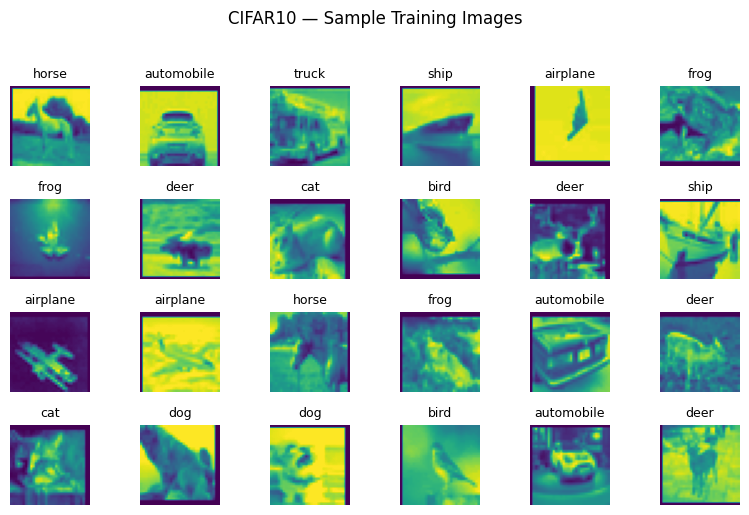

Batch tensor shape: torch.Size([128, 3, 32, 32]) | dtype: torch.float32


In [29]:
# I am going to look at the images again like I did at the beginning of this notebook. Reason being, I want to see if there are any changes...
# Just looking at the data. Returning a sample of 24 images with their corresponding labels. Categorical turned numberic once it hits the dataloader.
images, labels = next(iter(train_loader))
class_names = getattr(train_loader.dataset, "classes", [str(i) for i in range(10)])

k = 24
rows, cols = 4, 6
fig, axs = plt.subplots(rows, cols, figsize=(8,5))
axs = axs.ravel()
for i in range(k):
    axs[i].imshow(images[i, 0].numpy())
    axs[i].set_title(class_names[int(labels[i])], fontsize=9)
    axs[i].axis("off")
for j in range(k, rows*cols):
    axs[j].axis("off")
plt.suptitle("CIFAR10 — Sample Training Images", y=1.02)
plt.tight_layout()
plt.show()

print("Batch tensor shape:", images.shape, "| dtype:", images.dtype)

In [30]:

class CNN_and_Augmentation(nn.Module):
    def __init__(self, classes=10):
        super().__init__()

        # Throughout this class we will see bias=False in the nn.Conv2d layers where BatchNorm2d follows. This is because BatchNorm2d introduces its own learnable params...
        self.stem = nn.Sequential( # 2 3x3 convolution layers...
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias = False), # First conv layer.
            nn.BatchNorm2d(32), # Normalization
            nn.ReLU(), # Nonlinear activation function

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv_block_1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, padding=0, stride=1, bias = False), # Point-wise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, groups=128, bias = False), # Depth-wise convolution. Has to be same as in_channels and postive integer for out_channels.
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 convolution
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # Stacked 3x3 convolution.
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Downample with max pooling
        self.pooling1 = nn.MaxPool2d(2)

        self.conv_block_2 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0, stride=1, bias = False), #point-wise convolution on conv block 2
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, groups=256, bias = False), # depth-wise conv
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), #3x3 conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv stacked
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.pooling2 = nn.MaxPool2d(2)

        self.conv_block_3 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0, stride=1, bias = False), # point-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, groups=512, bias = False), #depth-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv layer
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # stacked 3x3
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        self.pooling3 = nn.MaxPool2d(2)

        # Flattening and linear (MLP head)
        self.fc = nn.Sequential(
            nn.Flatten(), # Flattening the dataset
            nn.Linear(1024 * 4 * 4, 2048), # 4x4 known from downsampling. Bias will remain its default of True here as no batch normalization follows...
            nn.ReLU(),
            #nn.Dropout(0.2), # Regularization technique. 20% dropped out in accordance to the assignment guidlines...

            nn.Linear(2048, 1024),
            nn.ReLU(),
            #nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.ReLU(),
            #nn.Dropout(0.2),

            nn.Linear(512, classes)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.conv_block_1(x)
        x = self.pooling1(x) # Max pooling step after conv block 1.
        x = self.conv_block_2(x)
        x = self.pooling2(x)
        x = self.conv_block_3(x)
        x = self.pooling3(x)
        x = self.fc(x)
        return x

In [31]:
# Model and optimizer
model = CNN_and_Augmentation().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [33]:
# Defining the training loop
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train epoch {epoch +1}: Loss={loss.item():.4f}')

In [34]:
# Defining the testing loop
def test():
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0,0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.numel()

            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
    acc = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.2f}%')

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Using actual class names
    class_names = getattr(test_loader.dataset, "classes", None)

    labels = np.arange(len(class_names))

    cm_raw  = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')  # sums to 1

    totals  = cm_raw.sum(axis=1)
    correct_per_class = np.diag(cm_raw)
    per_cls_acc = np.divide(correct_per_class, totals, out=np.zeros_like(correct_per_class, dtype=float), where=totals>0) * 100.0

    # Accuracy table per class
    print("Accuracy table classification")
    print(f"{'Class':<12} {'Correct/Total':>16} {'Accuracy %':>12}")
    for i, name in enumerate(class_names):
        ct = f"{int(correct_per_class[i])}/{int(totals[i])}"
        print(f"{name:<12} {ct:>16} {per_cls_acc[i]:>12.2f}")

    # Confusion matrix
    np.set_printoptions(linewidth=160, suppress=True)
    print("Confusion Matrix (raw counts):\n", cm_raw)
    print("Confusion Matrix (row-normalized):\n", cm_norm)

    # Brief interpretation: top 5 confusions
    off = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_norm[i, j] > 0:
                off.append((cm_norm[i, j], i, j))
    off.sort(reverse=True)
    print("Notable confusions (top 5):")
    for v, i, j in off[:5]:
        print(f"  {class_names[i]} was misclassified as: {class_names[j]}: {v*100:.2f}%")

    ConfusionMatrixDisplay(cm_raw, display_labels=class_names).plot(values_format='d'); plt.title("Raw Count"); plt.show()
    ConfusionMatrixDisplay(cm_norm, display_labels=class_names).plot(values_format='.2f'); plt.title("Normalized"); plt.show()

Train epoch 1: Loss=1.7244
Train epoch 2: Loss=1.4692
Train epoch 3: Loss=1.2035
Train epoch 4: Loss=0.9489
Train epoch 5: Loss=0.4702
Test Accuracy: 67.79%
Accuracy table classification
Class           Correct/Total   Accuracy %
airplane             715/1000        71.50
automobile           881/1000        88.10
bird                 464/1000        46.40
cat                  660/1000        66.00
deer                 409/1000        40.90
dog                  346/1000        34.60
frog                 790/1000        79.00
horse                739/1000        73.90
ship                 836/1000        83.60
truck                939/1000        93.90
Confusion Matrix (raw counts):
 [[715  25  29   7   1   0   4   2 108 109]
 [  7 881   1   1   0   0   0   0  18  92]
 [146  18 464 135  34  12 101  34  26  30]
 [ 36  19  53 660  12  21  74  39  21  65]
 [ 72  16  46 138 409   2 130 123  16  48]
 [ 19   9  63 428  10 346  10  83   6  26]
 [ 10  31  32  95   4   2 790   2  16  18]
 [ 41  

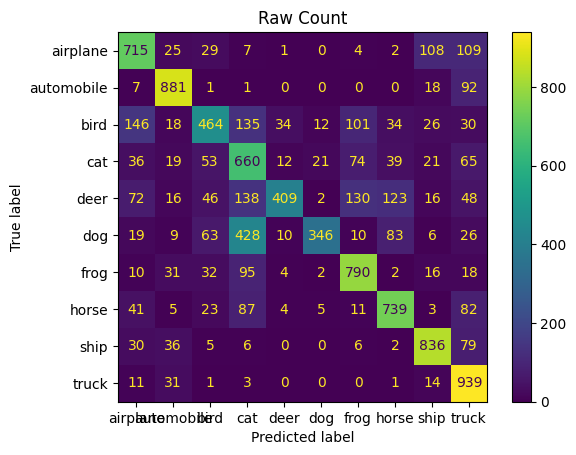

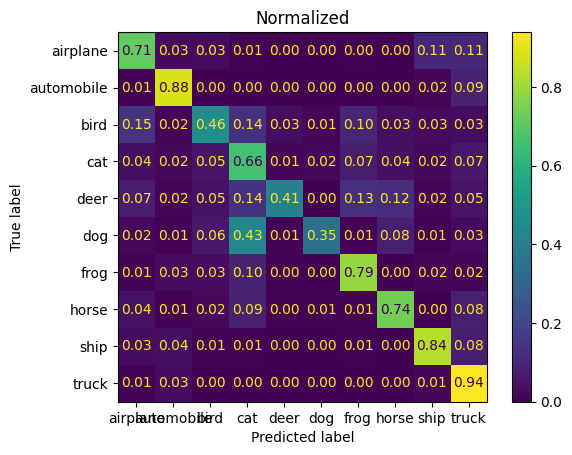

End of augmentation only model


In [35]:
# Performing train/test.
for epoch in range(5):
    train(epoch)
test()
print('End of augmentation only model')

In [ ]:
# Lastly we do the model that has dropout and augmentation implemented.
# NOTE, there is no need to read the images in again with augmentation since that was the last model run, but we need to uncomment the dropout portion of the CNN script.

In [37]:
class CNN_Dropout_And_Augmentation(nn.Module):
    def __init__(self, classes=10):
        super().__init__()

        # Throughout this class we will see bias=False in the nn.Conv2d layers where BatchNorm2d follows. This is because BatchNorm2d introduces its own learnable params...
        self.stem = nn.Sequential( # 2 3x3 convolution layers...
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias = False), # First conv layer.
            nn.BatchNorm2d(32), # Normalization
            nn.ReLU(), # Nonlinear activation function

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv_block_1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, padding=0, stride=1, bias = False), # Point-wise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, groups=128, bias = False), # Depth-wise convolution. Has to be same as in_channels and postive integer for out_channels.
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 convolution
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # Stacked 3x3 convolution.
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Downample with max pooling
        self.pooling1 = nn.MaxPool2d(2)

        self.conv_block_2 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0, stride=1, bias = False), #point-wise convolution on conv block 2
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, groups=256, bias = False), # depth-wise conv
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), #3x3 conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv stacked
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.pooling2 = nn.MaxPool2d(2)

        self.conv_block_3 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0, stride=1, bias = False), # point-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, groups=512, bias = False), #depth-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv layer
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # stacked 3x3
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        self.pooling3 = nn.MaxPool2d(2)

        # Flattening and linear (MLP head)
        self.fc = nn.Sequential(
            nn.Flatten(), # Flattening the dataset
            nn.Linear(1024 * 4 * 4, 2048), # 4x4 known from downsampling. Bias will remain its default of True here as no batch normalization follows...
            nn.ReLU(),
            nn.Dropout(0.2), # Regularization technique. 20% dropped out in accordance to the assignment guidlines...

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, classes)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.conv_block_1(x)
        x = self.pooling1(x) # Max pooling step after conv block 1.
        x = self.conv_block_2(x)
        x = self.pooling2(x)
        x = self.conv_block_3(x)
        x = self.pooling3(x)
        x = self.fc(x)
        return x

In [38]:
# Model and optimizer
model = CNN_Dropout_And_Augmentation().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [39]:
# Defining the training loop
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train epoch {epoch +1}: Loss={loss.item():.4f}')

In [40]:
# Defining the testing loop
def test():
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0,0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.numel()

            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
    acc = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.2f}%')

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Using actual class names
    class_names = getattr(test_loader.dataset, "classes", None)

    labels = np.arange(len(class_names))

    cm_raw  = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')  # sums to 1

    totals  = cm_raw.sum(axis=1)
    correct_per_class = np.diag(cm_raw)
    per_cls_acc = np.divide(correct_per_class, totals, out=np.zeros_like(correct_per_class, dtype=float), where=totals>0) * 100.0

    # Accuracy table per class
    print("Accuracy table classification")
    print(f"{'Class':<12} {'Correct/Total':>16} {'Accuracy %':>12}")
    for i, name in enumerate(class_names):
        ct = f"{int(correct_per_class[i])}/{int(totals[i])}"
        print(f"{name:<12} {ct:>16} {per_cls_acc[i]:>12.2f}")

    # Confusion matrix
    np.set_printoptions(linewidth=160, suppress=True)
    print("Confusion Matrix (raw counts):\n", cm_raw)
    print("Confusion Matrix (row-normalized):\n", cm_norm)

    # Brief interpretation: top 5 confusions
    off = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_norm[i, j] > 0:
                off.append((cm_norm[i, j], i, j))
    off.sort(reverse=True)
    print("Notable confusions (top 5):")
    for v, i, j in off[:5]:
        print(f"  {class_names[i]} was misclassified as: {class_names[j]}: {v*100:.2f}%")

    ConfusionMatrixDisplay(cm_raw, display_labels=class_names).plot(values_format='d'); plt.title("Raw Count"); plt.show()
    ConfusionMatrixDisplay(cm_norm, display_labels=class_names).plot(values_format='.2f'); plt.title("Normalized"); plt.show()

Train epoch 1: Loss=2.0168
Train epoch 2: Loss=1.7819
Train epoch 3: Loss=1.6109
Train epoch 4: Loss=1.4639
Train epoch 5: Loss=1.1329
Test Accuracy: 56.21%
Accuracy table classification
Class           Correct/Total   Accuracy %
airplane             736/1000        73.60
automobile           842/1000        84.20
bird                 177/1000        17.70
cat                  302/1000        30.20
deer                 360/1000        36.00
dog                  194/1000        19.40
frog                 656/1000        65.60
horse                625/1000        62.50
ship                 836/1000        83.60
truck                893/1000        89.30
Confusion Matrix (raw counts):
 [[736  16   9  15   5   0   0   8 128  83]
 [ 10 842   0   6   0   0   1   1  42  98]
 [231  17 177 105 177  17  75  82  37  82]
 [ 59  22  19 302  41  36  55  93  68 305]
 [ 85  15  20  40 360   1  44 246  21 168]
 [ 28  17  11 213  36 194   8 178  27 288]
 [ 34  38   8  54  35   1 656   8  58 108]
 [ 43  

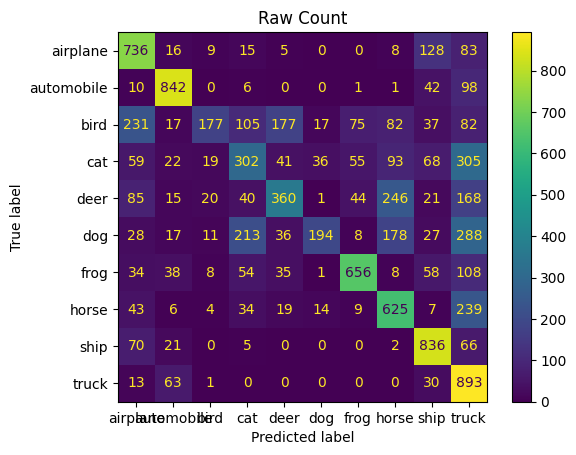

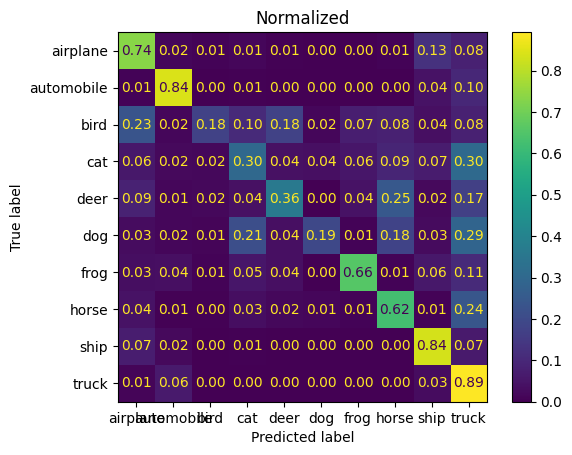

End of all model runs!


In [41]:
# Performing train/test.
for epoch in range(5):
    train(epoch)
test()
print('End of all model runs!')

# **Task 2**